In [29]:
# Standard imports
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from collections import OrderedDict

# Set up project paths
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

# Project imports
from vdm import networks_clean as networks
from vdm import vdm_model_clean as vdm_module
from bind.workflow_utils import ConfigLoader, ModelManager

# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Model and Data

In [31]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION IF NEEDED
# ============================================================================

# Model type: 'clean' (3-channel joint) or 'triple' (3 separate VDMs)
MODEL_TYPE = 'clean'

# Config file path - this will be used to automatically find the checkpoint
if MODEL_TYPE == 'clean':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_aggressive_stellar_restarts.ini'
else:
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_triple.ini'

# Load configuration (auto-finds best checkpoint)
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

# Verify checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}. Check your config file.")

# Load model (skip data loading for now - we'll load it separately)
print("\nLoading model...")
_, vdm_model = ModelManager.initialize(config, verbose=True, skip_data_loading=True)

# Get the UNet score model from the VDM
vdm_model = vdm_model.to(device)
vdm_model.eval()
score_model = vdm_model.model.score_model  # The UNet
print(f"Model loaded successfully!")
print(f"VDM type: {type(vdm_model).__name__}")
print(f"Score model type: {type(score_model).__name__}")

[ConfigLoader] Converted legacy_fourier=False to fourier_legacy
[ConfigLoader] conditioning_channels not in config or None, using default: 1
[ConfigLoader] 🌟 Quantile normalization enabled: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar_restarts.ini
[ConfigLoader] Parameters:
  seed: 8
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 96
  num_workers: 40
  cropsize: 128
  max_epochs: 100
  learning_rate: 0.0001
  lr_scheduler: cosine_restart
  noise_schedule: learned_nn
  gamma_min: -13.3
  gamma_max: 13.0
  data_noise: (0.001, 0.001, 0.001)
  antithetic_time_sampling: True
  n_blocks: 5
  embedding_dim: 96
  norm_groups: 8
  n_attention_heads: 16
  large_scale_channels: 3
  use_cross_attention: False
  add_attention: True
  use_fourier_features: True
  legacy_fourier: False
  lambdas: 1.0,

Seed set to 8


[ModelManager] Using fourier_legacy=False from config file (not auto-detecting)
[ModelManager] New multi-scale Fourier mode channel breakdown:
  Total conv_in: 39
  = input(3) + conditioning(1) + fourier_halo(8) + large_scale(3) + fourier_largescale(24)
[ModelManager] Final channel configuration:
  conditioning_channels: 1
  large_scale_channels: 3
  fourier_legacy: False
[ModelManager] Setting up parameter conditioning...
[ModelManager] Skipping dataset loading (inference-only mode)
[ModelManager] Creating UNetVDM model...
[ModelManager] Model configuration:
  - use_fourier_features: True
  - fourier_legacy: False
  - conditioning_channels: 1
  - large_scale_channels: 3
  - use_cross_attention: False
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter

In [32]:
# Print model architecture summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Summary:")
print(f"  Total trainable parameters: {count_parameters(score_model):,}")
print(f"  Embedding dimension: {score_model.embedding_dim}")
print(f"  Uses Fourier features: {score_model.use_fourier_features}")
print(f"  Uses cross-attention: {score_model.use_cross_attention}")
print(f"  Uses parameter conditioning: {score_model.use_param_conditioning}")
print(f"  Number of down blocks: {len(score_model.down_blocks)}")
print(f"  Number of up blocks: {len(score_model.up_blocks)}")


📊 Model Summary:
  Total trainable parameters: 247,765,832
  Embedding dimension: 96
  Uses Fourier features: True
  Uses cross-attention: False
  Uses parameter conditioning: True
  Number of down blocks: 5
  Number of up blocks: 5


In [33]:
# Load test data using ModelManager.initialize (same as training_validation.ipynb)
# Re-initialize with data loading enabled
test_loader, _ = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Get actual DataLoader from DataModule
actual_loader = test_loader.test_dataloader()
print(f"Test dataset size: {len(test_loader.dataset)}")

# Get a batch
test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
# (dm_condition, large_scale, target, params)
if len(batch) == 4:
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context: (B, 1, H, W) + (B, 3, H, W) -> (B, 4, H, W)
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

# Move to device and select first sample for analysis
target = targets[0:1].to(device)  # (1, 3, H, W)
condition = conditions[0:1].to(device)  # (1, C, H, W) where C = 1 + large_scale_channels
param = params[0:1].to(device) if params is not None else None

print(f"\nConditions shape (full batch): {conditions.shape}")
print(f"Targets shape (full batch): {targets.shape}")
print(f"\nSelected sample for analysis:")
print(f"  Target shape: {target.shape}")
print(f"  Condition shape: {condition.shape}")
if param is not None:
    print(f"  Params shape: {param.shape}")

[ModelManager] Defaulting to 'clean' model type
[ModelManager] Initializing CLEAN model (single 3-channel model)...
[ModelManager] Using seed: 8
[ModelManager] Dataset: IllustrisTNG
[ModelManager] Data root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
[ModelManager] Batch size: 96
[ModelManager] BEFORE auto-detect: conditioning_channels = 1
[ModelManager] BEFORE auto-detect: large_scale_channels = 3
[ModelManager] BEFORE auto-detect: use_fourier_features = True
[ModelManager] BEFORE auto-detect: fourier_legacy = False
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs/clean_vdm_aggressive_stellar_restarts/version_0//checkpoints/epoch=12-step=11076-val/elbo=-1.190.ckpt


Seed set to 8


[ModelManager] Using fourier_legacy=False from config file (not auto-detecting)
[ModelManager] New multi-scale Fourier mode channel breakdown:
  Total conv_in: 39
  = input(3) + conditioning(1) + fourier_halo(8) + large_scale(3) + fourier_largescale(24)
[ModelManager] Final channel configuration:
  conditioning_channels: 1
  large_scale_channels: 3
  fourier_legacy: False
[ModelManager] Setting up parameter conditioning...
[ModelManager] Loading dataset (stage='test')...
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
[ModelManager] Dataset loaded.
[ModelManager] Creating UNetVDM model...
[ModelManager] Model configuration:
  - use_fourier_features: True
  - fourier_legacy: False
  - conditioning_channels: 1
  - large_scale_channels

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Conditions shape (full batch): torch.Size([1, 4, 128, 128])
Targets shape (full batch): torch.Size([1, 3, 128, 128])

Selected sample for analysis:
  Target shape: torch.Size([1, 3, 128, 128])
  Condition shape: torch.Size([1, 4, 128, 128])
  Params shape: torch.Size([1, 35])


## 2. 🔥 Saliency Maps

Saliency maps show which input regions most influence the output. We compute the gradient of the output with respect to the input to identify important features.

In [34]:
def compute_saliency_map(model, z, g_t, conditioning, param_conditioning=None):
    """
    Compute saliency maps showing which input regions influence predictions.
    
    Args:
        model: The UNet score model
        z: Noisy input tensor (B, C, H, W)
        g_t: Gamma (noise level) tensor
        conditioning: Conditioning tensor (B, C_cond, H, W)
        param_conditioning: Optional parameter conditioning
    
    Returns:
        saliency_z: Saliency w.r.t. noisy input
        saliency_cond: Saliency w.r.t. conditioning
    """
    model.eval()
    
    # Enable gradients for inputs
    z = z.clone().requires_grad_(True)
    conditioning = conditioning.clone().requires_grad_(True)
    
    # Forward pass
    output = model(z, g_t, conditioning=conditioning, param_conditioning=param_conditioning)
    
    # Handle different return types
    if isinstance(output, tuple):
        prediction = output[0]
    else:
        prediction = output
    
    # Compute gradients w.r.t. inputs
    # Use sum of absolute prediction as scalar objective
    loss = prediction.abs().sum()
    loss.backward()
    
    # Get saliency (absolute gradient)
    saliency_z = z.grad.abs().detach()
    saliency_cond = conditioning.grad.abs().detach()
    
    return saliency_z, saliency_cond

Gamma range: [-13.3, 13.0]


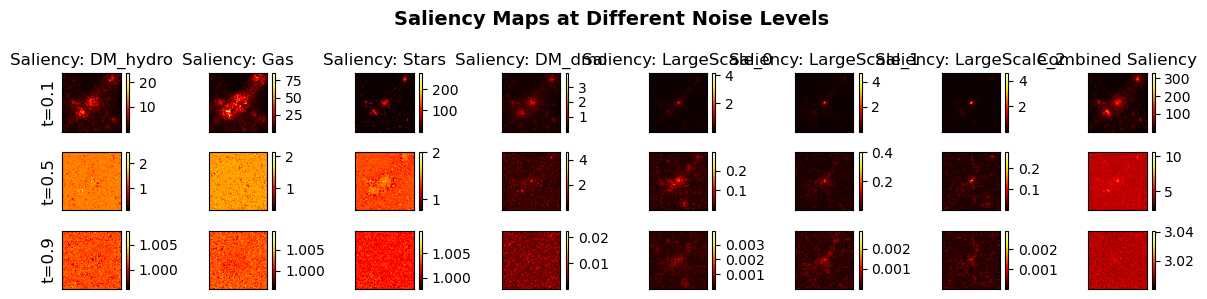

In [39]:
# Get gamma range from the VDM model (not score_model)
gamma_min = vdm_model.hparams.gamma_min
gamma_max = vdm_model.hparams.gamma_max
print(f"Gamma range: [{gamma_min}, {gamma_max}]")

def visualize_saliency(target, condition, score_model, param_conditioning=None, 
                       timesteps=[0.1, 0.5, 0.9], figsize=(12, 3)):
    """
    Visualize saliency maps at different noise levels.
    
    Args:
        target: Ground truth target (B, 3, H, W)
        condition: Full conditioning tensor (B, C, H, W) where C = 1 + large_scale_channels
        score_model: The UNet score model
        param_conditioning: Optional parameter conditioning (B, N_params)
        timesteps: List of normalized timesteps [0, 1]
    """
    n_times = len(timesteps)
    n_target_ch = target.shape[1]
    n_cond_ch = condition.shape[1]
    
    channel_names_target = ['DM_hydro', 'Gas', 'Stars']
    channel_names_cond = ['DM_dmo'] + [f'LargeScale_{i}' for i in range(n_cond_ch - 1)]
    
    fig, axes = plt.subplots(n_times, n_target_ch + n_cond_ch + 1, figsize=figsize)
    
    for row, t in enumerate(timesteps):
        # Convert normalized timestep to gamma
        g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], device=device)
        
        # Add noise to target
        noise = torch.randn_like(target)
        alpha_t = torch.sqrt(torch.sigmoid(-g_t)).view(-1, 1, 1, 1)
        sigma_t = torch.sqrt(torch.sigmoid(g_t)).view(-1, 1, 1, 1)
        z_noisy = alpha_t * target + sigma_t * noise
        
        # Compute saliency
        saliency_z, saliency_cond = compute_saliency_map(
            score_model, z_noisy, g_t, condition, param_conditioning
        )
        
        # Plot target saliency channels
        for ch in range(n_target_ch):
            ax = axes[row, ch]
            im = ax.imshow(saliency_z[0, ch].cpu().numpy(), cmap='hot')
            plt.colorbar(im, ax=ax, fraction=0.046)
            if row == 0:
                ax.set_title(f'Saliency: {channel_names_target[ch]}')
            if ch == 0:
                ax.set_ylabel(f't={t:.1f}', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Plot condition saliency channels
        for ch in range(n_cond_ch):
            ax = axes[row, n_target_ch + ch]
            im = ax.imshow(saliency_cond[0, ch].cpu().numpy(), cmap='hot')
            plt.colorbar(im, ax=ax, fraction=0.046)
            if row == 0:
                ax.set_title(f'Saliency: {channel_names_cond[ch]}')
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Combined saliency (sum across all channels)
        ax = axes[row, -1]
        combined = saliency_z.sum(dim=1) + saliency_cond.sum(dim=1)
        im = ax.imshow(combined[0].cpu().numpy(), cmap='hot')
        plt.colorbar(im, ax=ax, fraction=0.046)
        if row == 0:
            ax.set_title('Combined Saliency')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle('Saliency Maps at Different Noise Levels', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
# Compute and visualize saliency
visualize_saliency(target, condition, score_model, param_conditioning=param)

## 3. 🧠 Bottleneck Feature Extraction

Extract and analyze the latent representations from the UNet bottleneck. These features represent the model's compressed understanding of the input.

In [40]:
class FeatureExtractor:
    """
    Extract intermediate features from the UNet using hooks.
    """
    def __init__(self, model):
        self.model = model
        self.features = OrderedDict()
        self.hooks = []
        
    def _get_hook(self, name):
        def hook(module, input, output):
            if isinstance(output, tuple):
                self.features[name] = output[0].detach()
            else:
                self.features[name] = output.detach()
        return hook
    
    def register_hooks(self, layer_names=None):
        """Register hooks on specified layers or all key layers."""
        self.features = OrderedDict()
        
        # Default layers to capture
        if layer_names is None:
            # Register hooks on key architectural components
            # conv_in
            self.hooks.append(
                self.model.conv_in.register_forward_hook(self._get_hook('conv_in'))
            )
            
            # Down blocks
            for i, block in enumerate(self.model.down_blocks):
                self.hooks.append(
                    block.register_forward_hook(self._get_hook(f'down_block_{i}'))
                )
            
            # Middle blocks (bottleneck)
            if hasattr(self.model, 'mid_resnet_block_1'):
                self.hooks.append(
                    self.model.mid_resnet_block_1.register_forward_hook(self._get_hook('mid_resnet_1'))
                )
                if hasattr(self.model, 'mid_attn_block') and self.model.mid_attn_block is not None:
                    self.hooks.append(
                        self.model.mid_attn_block.register_forward_hook(self._get_hook('mid_attention'))
                    )
                self.hooks.append(
                    self.model.mid_resnet_block_2.register_forward_hook(self._get_hook('mid_resnet_2'))
                )
            elif hasattr(self.model, 'mid_resnet_block'):
                self.hooks.append(
                    self.model.mid_resnet_block.register_forward_hook(self._get_hook('mid_resnet'))
                )
            
            # Up blocks
            for i, block in enumerate(self.model.up_blocks):
                self.hooks.append(
                    block.register_forward_hook(self._get_hook(f'up_block_{i}'))
                )
            
            # conv_out
            self.hooks.append(
                self.model.conv_out.register_forward_hook(self._get_hook('conv_out'))
            )
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def extract_features(self, z, g_t, conditioning, param_conditioning=None):
        """Run forward pass and return captured features."""
        self.features = OrderedDict()
        with torch.no_grad():
            _ = self.model(z, g_t, conditioning=conditioning, param_conditioning=param_conditioning)
        return self.features

In [41]:
# Extract features at a specific noise level
extractor = FeatureExtractor(score_model)
extractor.register_hooks()

# Use mid-noise level for analysis
t = 0.5
g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], device=device)

# Add noise
noise = torch.randn_like(target)
alpha_t = torch.sqrt(torch.sigmoid(-g_t)).view(-1, 1, 1, 1)
sigma_t = torch.sqrt(torch.sigmoid(g_t)).view(-1, 1, 1, 1)
z_noisy = alpha_t * target + sigma_t * noise

# Extract features
features = extractor.extract_features(z_noisy, g_t, condition, param_conditioning=param)
extractor.remove_hooks()

print("\n📊 Extracted Features:")
for name, feat in features.items():
    print(f"  {name}: shape={feat.shape}, mean={feat.mean():.4f}, std={feat.std():.4f}")


📊 Extracted Features:
  conv_in: shape=torch.Size([1, 96, 128, 128]), mean=-0.0355, std=0.4868
  down_block_0: shape=torch.Size([1, 96, 64, 64]), mean=0.0417, std=0.3313
  down_block_1: shape=torch.Size([1, 192, 32, 32]), mean=0.0091, std=0.2302
  down_block_2: shape=torch.Size([1, 384, 16, 16]), mean=0.1109, std=0.6506
  down_block_3: shape=torch.Size([1, 768, 8, 8]), mean=0.1492, std=1.0150
  down_block_4: shape=torch.Size([1, 1024, 4, 4]), mean=-0.1546, std=0.9456
  mid_resnet_1: shape=torch.Size([1, 2048, 4, 4]), mean=-0.4040, std=1.2870
  mid_attention: shape=torch.Size([1, 2048, 4, 4]), mean=-0.3703, std=1.3974
  mid_resnet_2: shape=torch.Size([1, 2048, 4, 4]), mean=-0.3545, std=1.5675
  up_block_0: shape=torch.Size([1, 1024, 8, 8]), mean=-0.0238, std=1.0546
  up_block_1: shape=torch.Size([1, 512, 16, 16]), mean=-0.0458, std=0.9020
  up_block_2: shape=torch.Size([1, 256, 32, 32]), mean=0.0151, std=0.9776
  up_block_3: shape=torch.Size([1, 128, 64, 64]), mean=0.0377, std=0.7087
 


🧠 Bottleneck features from 'mid_resnet_2':
  Shape: torch.Size([1, 2048, 4, 4])
  Mean: -0.3545
  Std: 1.5675
  Min: -8.2391
  Max: 6.2636


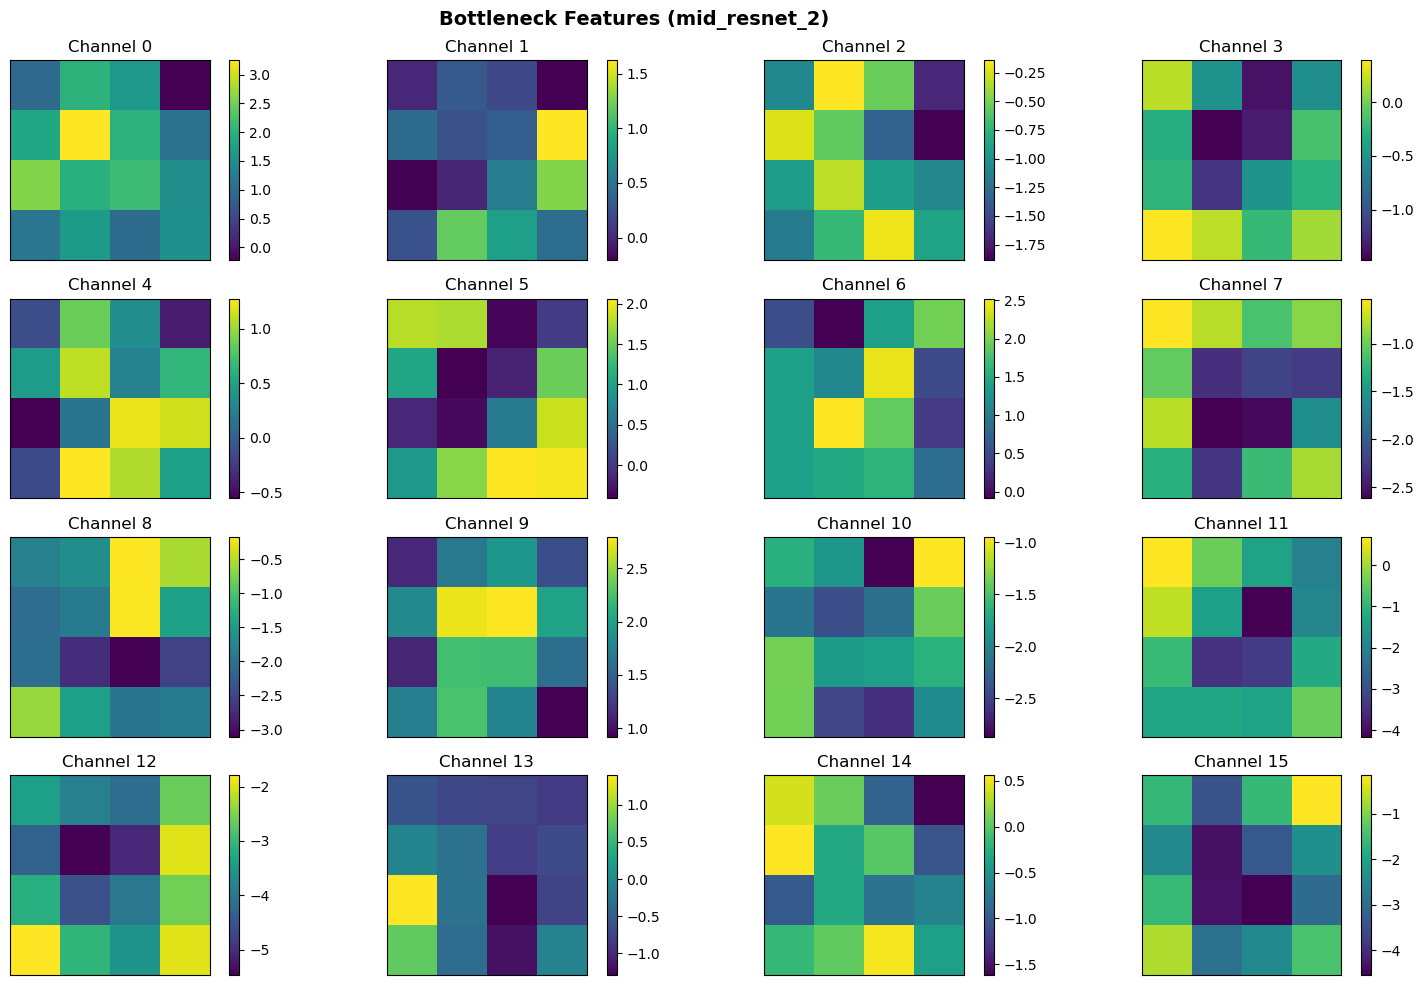

In [42]:
def visualize_bottleneck_features(features, n_channels=16, figsize=(16, 10)):
    """
    Visualize bottleneck feature maps.
    """
    # Find bottleneck layer
    bottleneck_keys = [k for k in features.keys() if 'mid' in k.lower()]
    if not bottleneck_keys:
        print("No bottleneck features found")
        return
    
    bottleneck_key = bottleneck_keys[-1]  # Use last mid layer
    bottleneck = features[bottleneck_key]
    
    print(f"\n🧠 Bottleneck features from '{bottleneck_key}':")
    print(f"  Shape: {bottleneck.shape}")
    print(f"  Mean: {bottleneck.mean():.4f}")
    print(f"  Std: {bottleneck.std():.4f}")
    print(f"  Min: {bottleneck.min():.4f}")
    print(f"  Max: {bottleneck.max():.4f}")
    
    # Plot subset of channels
    n_show = min(n_channels, bottleneck.shape[1])
    n_cols = 4
    n_rows = (n_show + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(n_show):
        ax = axes[i]
        im = ax.imshow(bottleneck[0, i].cpu().numpy(), cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046)
        ax.set_title(f'Channel {i}')
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide unused axes
    for i in range(n_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Bottleneck Features ({bottleneck_key})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_bottleneck_features(features)

In [60]:
# Install umap-learn if needed (uncomment if not installed)
# !pip install umap-learn

from sklearn.decomposition import PCA
try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("umap-learn not installed. Install with: pip install umap-learn")
    HAS_UMAP = False

2025-12-09 16:54:37.514575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 16:54:37.552289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [71]:
def extract_bottleneck_embeddings(score_model, dataloader, n_samples=100, t=0.5, random_sample=True):
    """
    Extract bottleneck features from multiple samples for dimensionality reduction.
    
    Args:
        score_model: The UNet score model
        dataloader: DataLoader with test samples
        n_samples: Number of samples to extract
        t: Normalized timestep for noise level
        random_sample: If True, randomly sample from dataset; if False, take first n_samples
    
    Returns:
        embeddings: (n_samples, n_features) array of flattened bottleneck features
        metadata: dict with halo masses, params, sample properties, etc.
    """
    score_model.eval()
    extractor = FeatureExtractor(score_model)
    extractor.register_hooks()
    
    embeddings = []
    metadata = {
        'params': [],           # Cosmological/astrophysical parameters
        'sample_idx': [],       # Sample index
        'dm_total': [],         # Total DM in condition (proxy for halo mass)
        'gas_total': [],        # Total gas in target
        'star_total': [],       # Total stars in target
        'dm_peak': [],          # Peak DM density
    }
    
    g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], 
                       device=device, dtype=torch.float32)
    
    # Get dataset size and create random indices if needed
    dataset = dataloader.dataset
    total_samples = len(dataset)
    
    if random_sample:
        # Randomly select indices from the full dataset
        n_to_sample = min(n_samples, total_samples)
        random_indices = np.random.choice(total_samples, size=n_to_sample, replace=False)
        print(f"Randomly sampling {n_to_sample} from {total_samples} total samples")
    else:
        random_indices = np.arange(min(n_samples, total_samples))
        print(f"Taking first {len(random_indices)} samples")
    
    sample_count = 0
    with torch.no_grad():
        for idx in random_indices:
            # Get single sample directly from dataset
            sample = dataset[idx]
            
            # Unpack sample (same structure as batch but without batch dimension)
            if len(sample) == 4:
                condition_dm, large_scale, target_data, params_data = sample
                # Add batch dimension and concatenate
                condition_dm = condition_dm.unsqueeze(0)
                large_scale = large_scale.unsqueeze(0)
                condition_data = torch.cat([condition_dm, large_scale], dim=1)
                target_data = target_data.unsqueeze(0)
                params_data = params_data.unsqueeze(0) if params_data is not None else None
            elif len(sample) == 3:
                condition_data, target_data, params_data = sample
                condition_data = condition_data.unsqueeze(0)
                target_data = target_data.unsqueeze(0)
                params_data = params_data.unsqueeze(0) if params_data is not None else None
            else:
                condition_data, target_data = sample
                condition_data = condition_data.unsqueeze(0)
                target_data = target_data.unsqueeze(0)
                params_data = None
            
            # Move to device
            target_i = target_data.to(device)
            condition_i = condition_data.to(device)
            param_i = params_data.to(device) if params_data is not None else None
            
            # Add noise
            noise = torch.randn_like(target_i)
            alpha_t = torch.sqrt(torch.sigmoid(-g_t)).view(-1, 1, 1, 1).float()
            sigma_t = torch.sqrt(torch.sigmoid(g_t)).view(-1, 1, 1, 1).float()
            z_noisy = alpha_t * target_i + sigma_t * noise
            
            # Extract features
            features = extractor.extract_features(z_noisy, g_t, condition_i, param_conditioning=param_i)
            
            # Get bottleneck features
            bottleneck_keys = [k for k in features.keys() if 'mid' in k.lower()]
            if bottleneck_keys:
                bottleneck = features[bottleneck_keys[-1]]
                # Global average pool to get (1, C) then flatten
                pooled = bottleneck.mean(dim=(2, 3))  # (1, C)
                embeddings.append(pooled.cpu().numpy().flatten())
            
            # Store metadata - halo properties (these vary a lot!)
            metadata['sample_idx'].append(idx)  # Store original dataset index
            if params_data is not None:
                metadata['params'].append(params_data[0].cpu().numpy())
            
            # Compute halo-level features from the data itself
            dm_cond = condition_data[0, 0].cpu().numpy()  # First channel is DM condition
            metadata['dm_total'].append(np.sum(dm_cond))
            metadata['dm_peak'].append(np.max(dm_cond))
            
            # Target channels: [DM_hydro, Gas, Stars]
            target_np = target_data[0].cpu().numpy()
            if target_np.shape[0] >= 3:
                metadata['gas_total'].append(np.sum(target_np[1]))
                metadata['star_total'].append(np.sum(target_np[2]))
            else:
                metadata['gas_total'].append(0)
                metadata['star_total'].append(0)
            
            sample_count += 1
            
            if sample_count % 20 == 0:
                print(f"Extracted {sample_count}/{n_samples} samples...")
    
    extractor.remove_hooks()
    
    embeddings = np.array(embeddings)
    print(f"Final embeddings shape: {embeddings.shape}")
    
    # Convert lists to arrays for easier manipulation
    for key in ['dm_total', 'dm_peak', 'gas_total', 'star_total', 'sample_idx']:
        metadata[key] = np.array(metadata[key])
    
    return embeddings, metadata

In [ ]:
def visualize_embeddings(embeddings, metadata, method='both', figsize=(14, 6), color_by='auto'):
    """
    Visualize bottleneck embeddings using PCA and/or UMAP.
    
    Args:
        embeddings: (n_samples, n_features) array
        metadata: dict with sample metadata for coloring
        method: 'pca', 'umap', or 'both'
        color_by: 'auto' (picks parameter with most variance), 'sample_idx', or param index (int)
    """
    n_plots = 2 if method == 'both' else 1
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Determine what to color by
    if metadata['params'] and len(metadata['params']) > 0:
        params_array = np.array(metadata['params'])
        print(f"Parameters shape: {params_array.shape}")
        
        if color_by == 'auto':
            # Find the parameter with the most variance (most interesting for visualization)
            if params_array.ndim > 1:
                param_stds = np.std(params_array, axis=0)
                param_ranges = np.ptp(params_array, axis=0)  # peak-to-peak (max - min)
                # Use coefficient of variation (std/mean) to find most varying parameter
                param_means = np.abs(np.mean(params_array, axis=0)) + 1e-10
                param_cv = param_stds / param_means
                best_param_idx = np.argmax(param_cv)
                colors = params_array[:, best_param_idx]
                color_label = f'Param[{best_param_idx}]'
                print(f"Auto-selected parameter {best_param_idx} (highest relative variance)")
                print(f"  Range: [{colors.min():.4f}, {colors.max():.4f}]")
                print(f"  Std: {colors.std():.4f}")
            else:
                colors = params_array
                color_label = 'Parameter'
        elif isinstance(color_by, int):
            colors = params_array[:, color_by] if params_array.ndim > 1 else params_array
            color_label = f'Param[{color_by}]'
        else:  # 'sample_idx'
            colors = np.array(metadata['sample_idx'])
            color_label = 'Sample Index'
        
        # Print parameter statistics for first few params
        print("\nParameter statistics (first 6):")
        n_show = min(6, params_array.shape[1] if params_array.ndim > 1 else 1)
        param_names_guess = ['Ω_m', 'σ_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2']
        for i in range(n_show):
            vals = params_array[:, i] if params_array.ndim > 1 else params_array
            name = param_names_guess[i] if i < len(param_names_guess) else f'Param[{i}]'
            print(f"  {name}: range=[{vals.min():.4f}, {vals.max():.4f}], std={vals.std():.4f}")
    else:
        colors = np.array(metadata['sample_idx'])
        color_label = 'Sample Index'
    
    # PCA
    if method in ['pca', 'both']:
        print("\nComputing PCA...")
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(embeddings)
        
        ax = axes[plot_idx]
        scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], 
                            c=colors, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter, ax=ax, label=color_label)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title('PCA of Bottleneck Features')
        ax.grid(True, alpha=0.3)
        plot_idx += 1
        
        print(f"PCA explained variance: {pca.explained_variance_ratio_[:2].sum()*100:.1f}%")
    
    # UMAP
    if method in ['umap', 'both'] and HAS_UMAP:
        print("Computing UMAP (this may take a moment)...")
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, metric='euclidean', random_state=42)
        umap_result = reducer.fit_transform(embeddings)
        
        ax = axes[plot_idx]
        scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1], 
                            c=colors, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter, ax=ax, label=color_label)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title('UMAP of Bottleneck Features')
        ax.grid(True, alpha=0.3)
    elif method in ['umap', 'both'] and not HAS_UMAP:
        ax = axes[plot_idx]
        ax.text(0.5, 0.5, 'UMAP not available\nInstall with: pip install umap-learn', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('UMAP (not installed)')
    
    plt.suptitle('Bottleneck Feature Space Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

Extracting bottleneck embeddings from randomly sampled test data...
Randomly sampling 2000 from 42720 total samples
Extracted 20/2000 samples...
Extracted 20/2000 samples...
Extracted 40/2000 samples...
Extracted 40/2000 samples...
Extracted 60/2000 samples...
Extracted 60/2000 samples...
Extracted 80/2000 samples...
Extracted 80/2000 samples...
Extracted 100/2000 samples...
Extracted 100/2000 samples...
Extracted 120/2000 samples...
Extracted 120/2000 samples...
Extracted 140/2000 samples...
Extracted 140/2000 samples...
Extracted 160/2000 samples...
Extracted 160/2000 samples...
Extracted 180/2000 samples...
Extracted 180/2000 samples...
Extracted 200/2000 samples...
Extracted 200/2000 samples...
Extracted 220/2000 samples...
Extracted 220/2000 samples...
Extracted 240/2000 samples...
Extracted 240/2000 samples...
Extracted 260/2000 samples...
Extracted 260/2000 samples...
Extracted 280/2000 samples...
Extracted 280/2000 samples...
Extracted 300/2000 samples...
Extracted 300/2000 sam

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


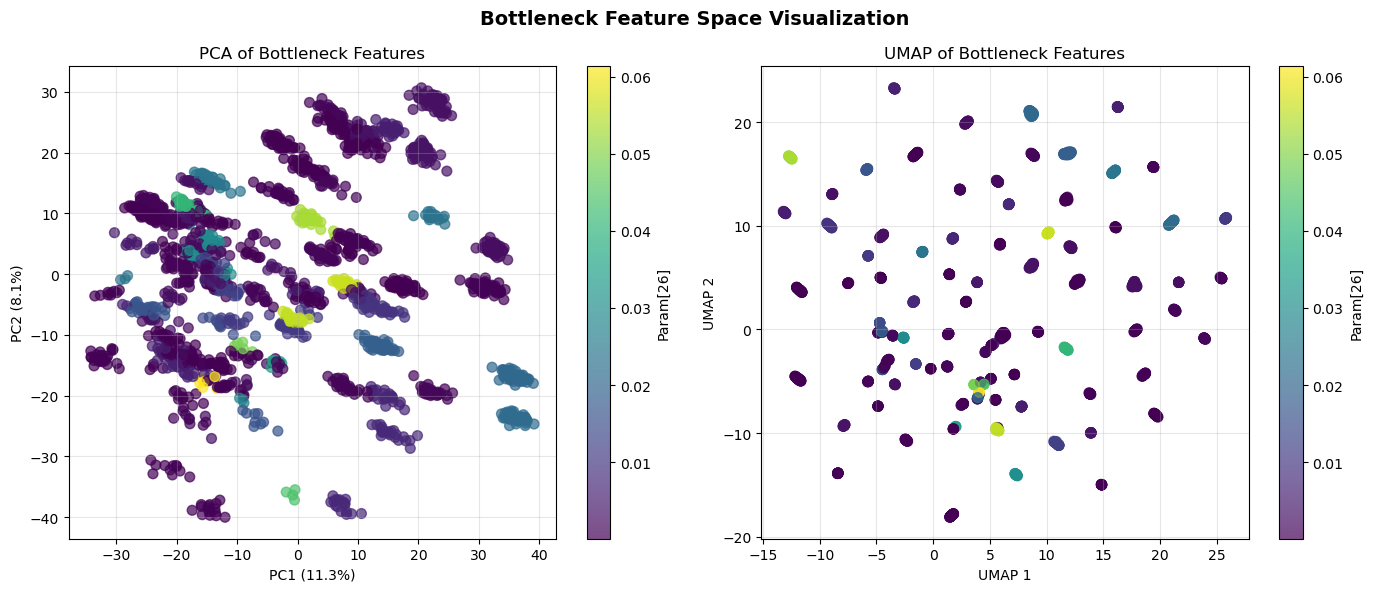

In [78]:
# Extract embeddings from RANDOMLY SAMPLED test samples
# This ensures better coverage of the parameter space
np.random.seed(42)  # For reproducibility

print("Extracting bottleneck embeddings from randomly sampled test data...")
embeddings, metadata = extract_bottleneck_embeddings(
    score_model, 
    actual_loader, 
    n_samples=2000,      # Number of samples to extract
    t=0.5,              # Mid-noise level
    random_sample=True  # Randomly sample from full dataset
)

# Print metadata statistics
print("\n📊 Halo Property Statistics (these vary more than cosmology!):")
print(f"  DM Total: range=[{metadata['dm_total'].min():.2f}, {metadata['dm_total'].max():.2f}], std={metadata['dm_total'].std():.2f}")
print(f"  DM Peak:  range=[{metadata['dm_peak'].min():.2f}, {metadata['dm_peak'].max():.2f}], std={metadata['dm_peak'].std():.2f}")
print(f"  Gas Total: range=[{metadata['gas_total'].min():.2f}, {metadata['gas_total'].max():.2f}], std={metadata['gas_total'].std():.2f}")
print(f"  Star Total: range=[{metadata['star_total'].min():.2f}, {metadata['star_total'].max():.2f}], std={metadata['star_total'].std():.2f}")

# Visualize with PCA and UMAP
visualize_embeddings(embeddings, metadata, method='both')

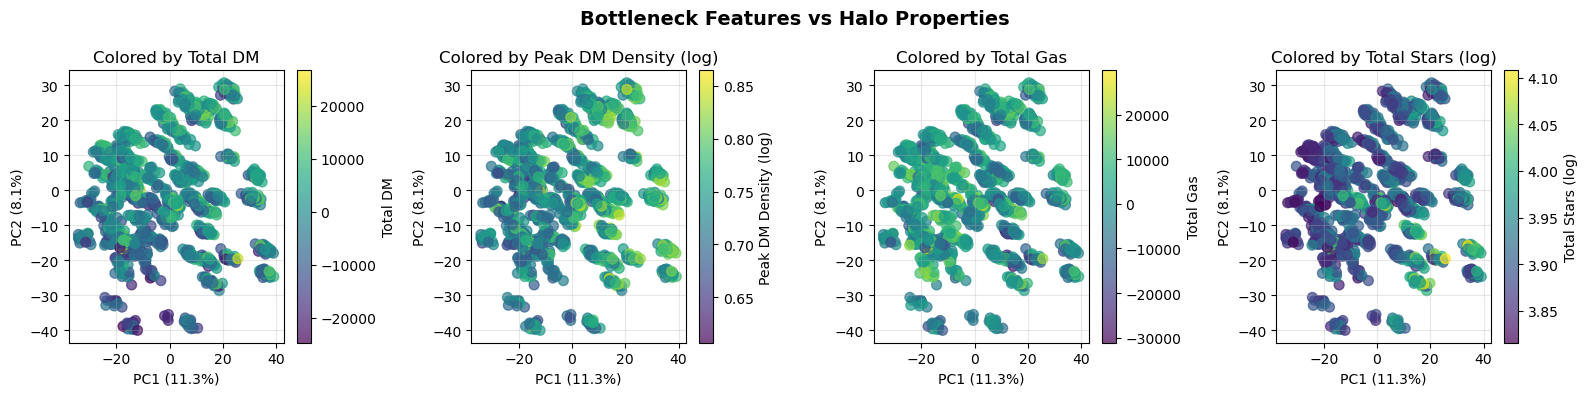

In [80]:
# Visualize embeddings colored by HALO PROPERTIES (much more variation!)
def visualize_embeddings_by_halo_properties(embeddings, metadata, figsize=(16, 4)):
    """
    Visualize embeddings colored by halo properties (DM mass, gas, stars).
    These vary much more than cosmological parameters in a fixed-cosmology test set.
    """
    # Compute PCA once
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    properties = [
        ('dm_total', 'Total DM (log)', True),
        ('dm_peak', 'Peak DM Density (log)', True),
        ('gas_total', 'Total Gas (log)', True),
        ('star_total', 'Total Stars (log)', True),
    ]
    
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    for ax, (key, label, use_log) in zip(axes, properties):
        values = metadata[key]
        if use_log and np.all(values > 0):
            colors = np.log10(values + 1e-10)
            label = label
        else:
            colors = values
            label = label.replace(' (log)', '')
        
        scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], 
                            c=colors, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter, ax=ax, label=label)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title(f'Colored by {label}')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Bottleneck Features vs Halo Properties', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_embeddings_by_halo_properties(embeddings, metadata)

Visualizing all 35 parameters using UMAP
Computing UMAP embedding (this may take a moment)...


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP complete!


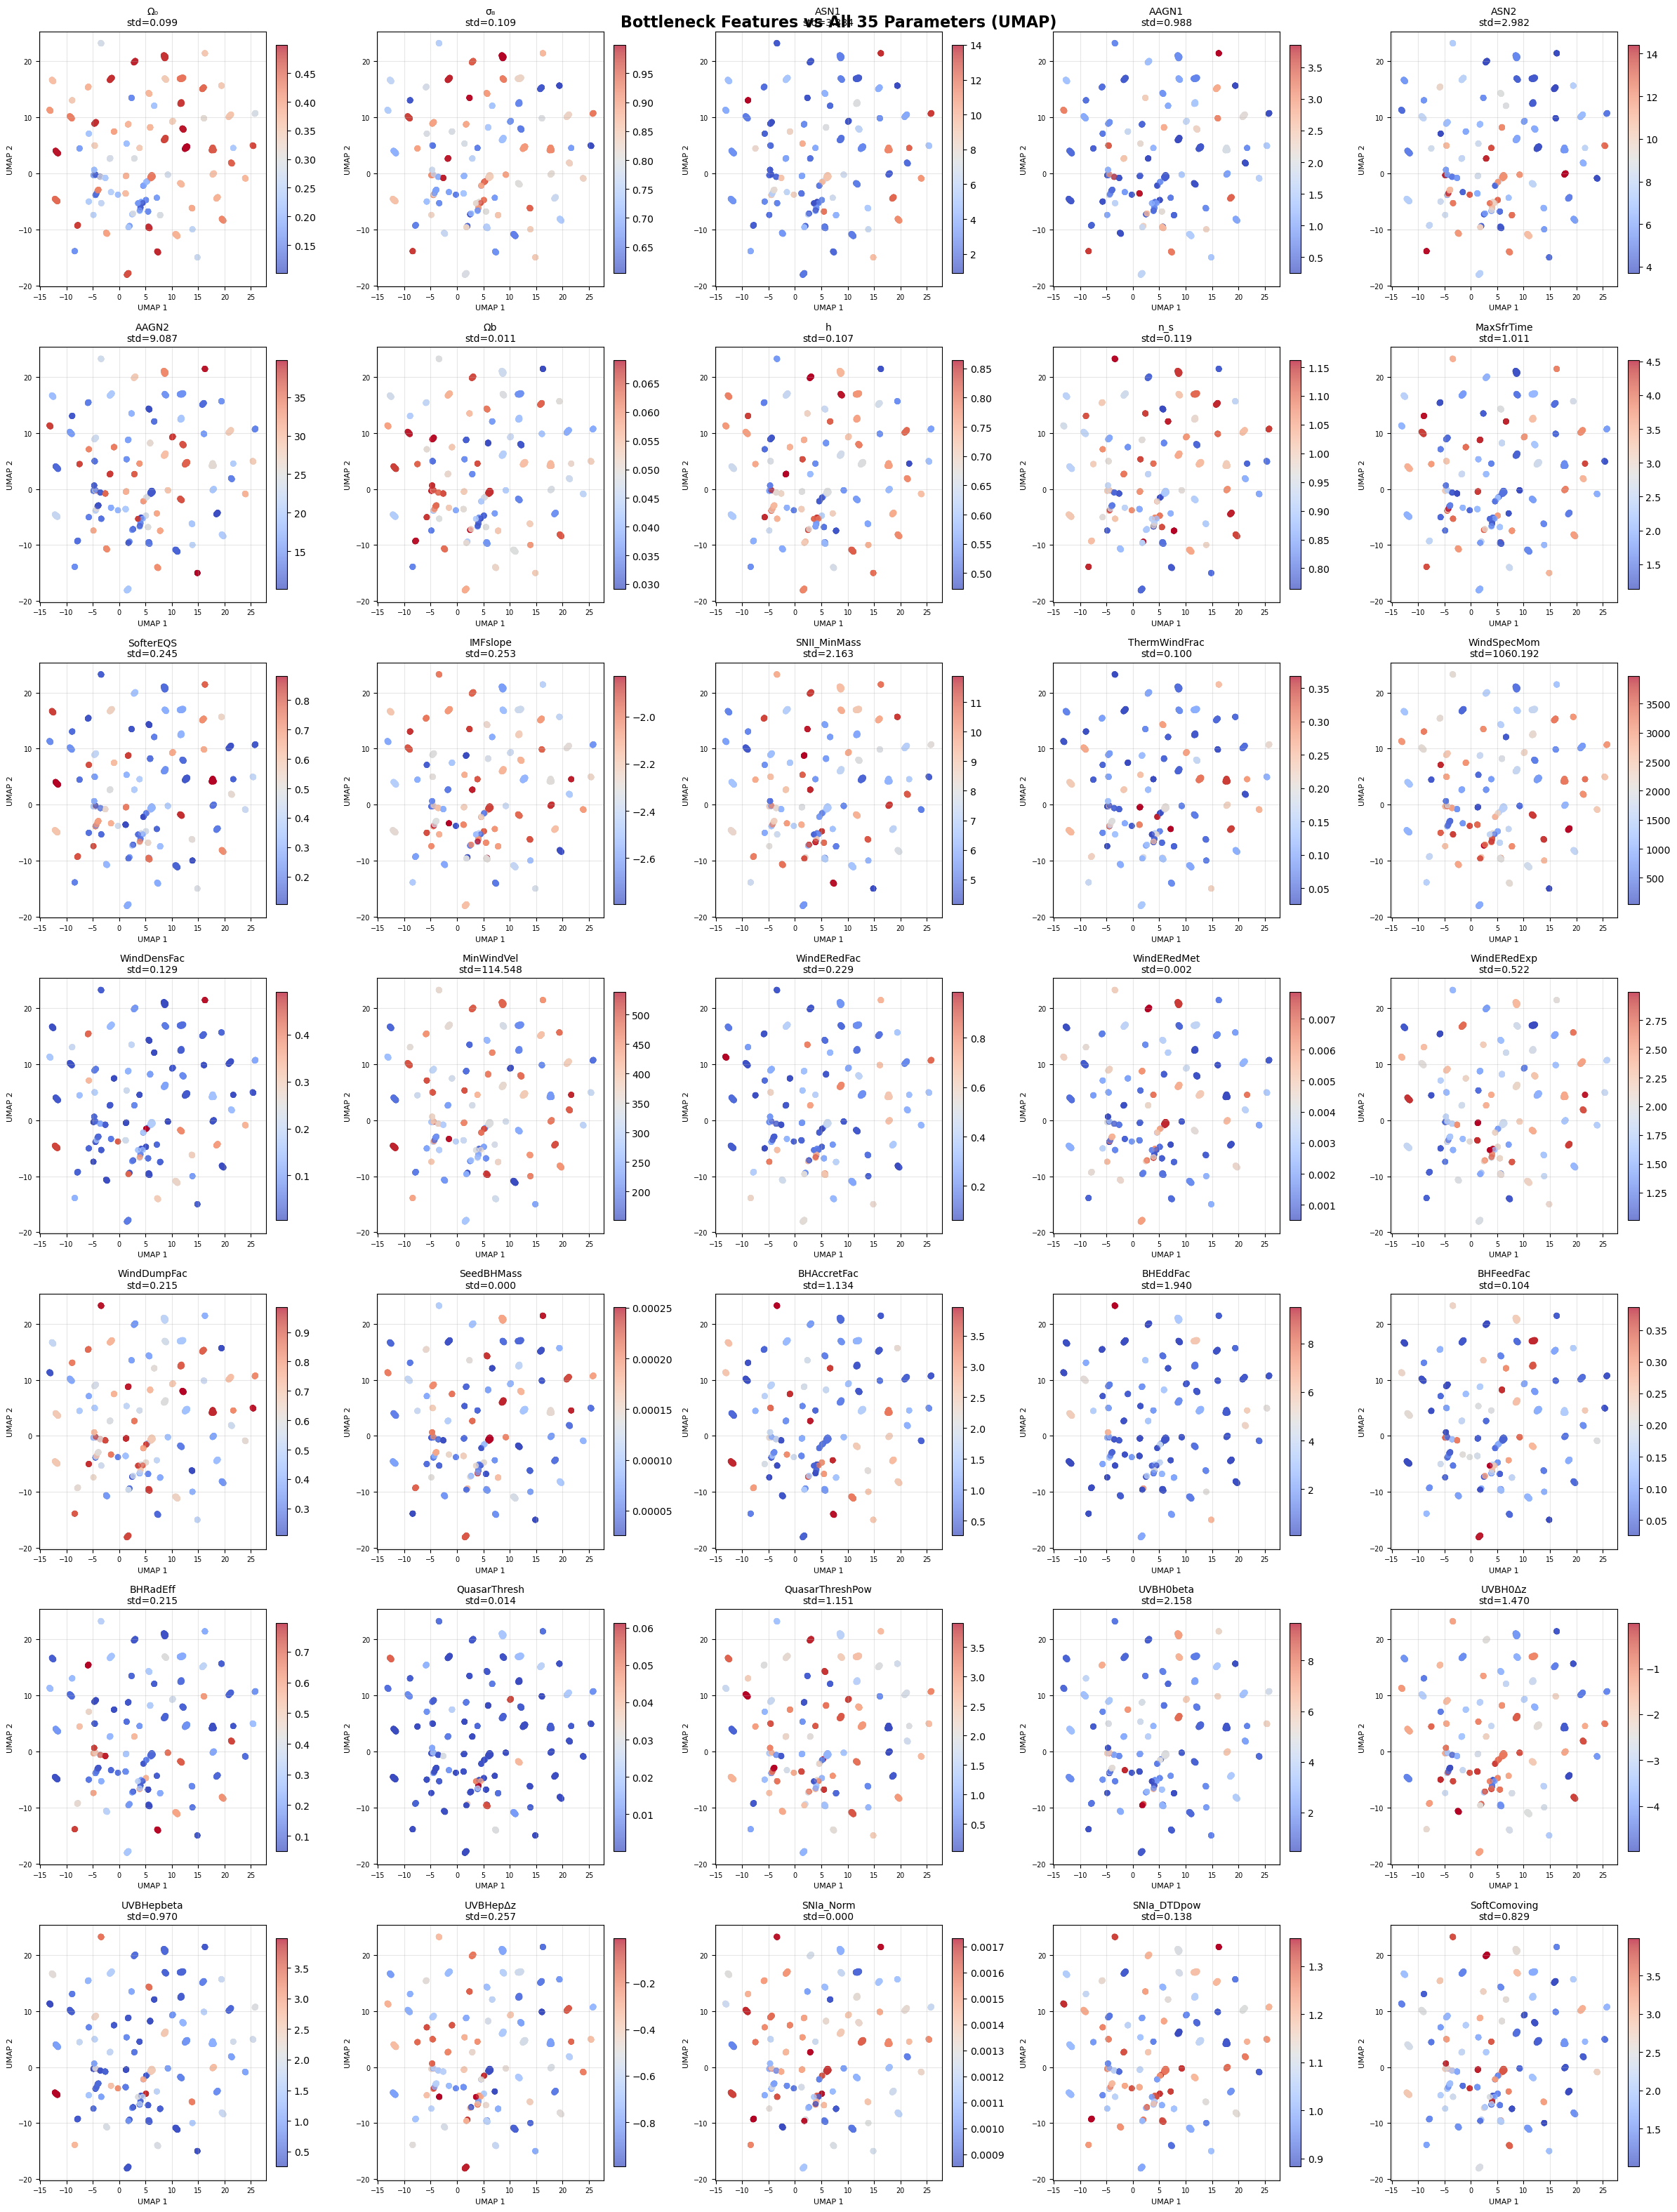


📊 Parameter Variation Summary:
------------------------------------------------------------
               Ω₀: range=[    0.1011,     0.4996], std=0.0991
               σ₈: range=[    0.6046,     0.9994], std=0.1094
             ASN1: range=[    0.9037,    14.0050], std=3.3839
            AAGN1: range=[    0.2502,     3.8541], std=0.9877
             ASN2: range=[    3.7056,    14.4120], std=2.9825
            AAGN2: range=[   10.1230,    39.7680], std=9.0871
               Ωb: range=[    0.0292,     0.0690], std=0.0113
                h: range=[    0.4734,     0.8637], std=0.1071
              n_s: range=[    0.7644,     1.1618], std=0.1189
       MaxSfrTime: range=[    1.1405,     4.5136], std=1.0108
        SofterEQS: range=[    0.1059,     0.8822], std=0.2450
         IMFslope: range=[   -2.7961,    -1.8283], std=0.2526
     SNII_MinMass: range=[    4.1592,    11.8840], std=2.1628
    ThermWindFrac: range=[    0.0262,     0.3683], std=0.0997
      WindSpecMom: range=[   44.2170,  

In [82]:
# Define the 35 SB35 parameter names (from SB35_param_minmax.csv)
SB35_PARAM_NAMES = [
    'Ω₀', 'σ₈', 'ASN1', 'AAGN1', 'ASN2', 'AAGN2',
    'Ωb', 'h', 'n_s', 'MaxSfrTime', 'SofterEQS', 'IMFslope',
    'SNII_MinMass', 'ThermWindFrac', 'WindSpecMom', 'WindDensFac',
    'MinWindVel', 'WindERedFac', 'WindERedMet', 'WindERedExp',
    'WindDumpFac', 'SeedBHMass', 'BHAccretFac', 'BHEddFac',
    'BHFeedFac', 'BHRadEff', 'QuasarThresh', 'QuasarThreshPow',
    'UVBH0beta', 'UVBH0Δz', 'UVBHepbeta', 'UVBHepΔz',
    'SNIa_Norm', 'SNIa_DTDpow', 'SoftComoving'
]

def visualize_embeddings_by_params(embeddings, metadata, param_names=None, figsize=(24, 32)):
    """
    Visualize embeddings colored by ALL cosmological/astrophysical parameters using UMAP.
    
    Args:
        embeddings: (n_samples, n_features) array
        metadata: dict with 'params' containing parameter arrays
        param_names: List of parameter names (default: SB35 parameter names)
    """
    if not metadata['params'] or len(metadata['params']) == 0:
        print("No parameter metadata available")
        return
    
    if not HAS_UMAP:
        print("UMAP not available. Install with: pip install umap-learn")
        return
    
    params_array = np.array(metadata['params'])
    n_params = params_array.shape[1] if params_array.ndim > 1 else 1
    
    print(f"Visualizing all {n_params} parameters using UMAP")
    
    # Use SB35 parameter names by default
    if param_names is None:
        param_names = SB35_PARAM_NAMES if n_params <= 35 else SB35_PARAM_NAMES + [f'P{i}' for i in range(35, n_params)]
    
    # Compute UMAP once
    print("Computing UMAP embedding (this may take a moment)...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
    umap_result = reducer.fit_transform(embeddings)
    print("UMAP complete!")
    
    # Create 7x5 grid for 35 parameters
    n_rows, n_cols = 7, 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(min(n_params, n_rows * n_cols)):
        ax = axes[i]
        if params_array.ndim > 1:
            colors = params_array[:, i]
        else:
            colors = params_array
        
        # Check if parameter has any variation
        param_std = np.std(colors)
        param_range = np.ptp(colors)
        
        scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1], 
                            c=colors, cmap='coolwarm', alpha=0.7, s=25)
        plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        
        # Use parameter name if available
        pname = param_names[i] if i < len(param_names) else f'P{i}'
        ax.set_title(f'{pname}\nstd={param_std:.3f}', fontsize=10)
        ax.set_xlabel('UMAP 1', fontsize=8)
        ax.set_ylabel('UMAP 2', fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Hide any unused axes
    for i in range(n_params, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f'Bottleneck Features vs All {n_params} Parameters (UMAP)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary of parameter variation
    print("\n📊 Parameter Variation Summary:")
    print("-" * 60)
    for i in range(n_params):
        vals = params_array[:, i] if params_array.ndim > 1 else params_array
        pname = param_names[i] if i < len(param_names) else f'P{i}'
        std = np.std(vals)
        rng = np.ptp(vals)
        # Flag parameters with very low variation
        flag = " ⚠️ LOW VARIANCE" if std < 0.01 else ""
        print(f"  {pname:>15}: range=[{vals.min():10.4f}, {vals.max():10.4f}], std={std:.4f}{flag}")

# Visualize how bottleneck encodes different parameters
if metadata['params'] and len(metadata['params']) > 0:
    visualize_embeddings_by_params(embeddings, metadata)
else:
    print("No parameter data available for visualization")

## 4. 📊 Feature Statistics Analysis

Analyze statistics of features across all layers to understand information flow through the network.

In [43]:
def analyze_feature_statistics(features):
    """
    Compute detailed statistics for each layer's features.
    """
    stats = OrderedDict()
    
    for name, feat in features.items():
        feat_np = feat.cpu().numpy()
        stats[name] = {
            'shape': feat.shape,
            'mean': float(feat.mean()),
            'std': float(feat.std()),
            'min': float(feat.min()),
            'max': float(feat.max()),
            'sparsity': float((feat.abs() < 0.01).float().mean()),  # % of near-zero activations
            'spatial_size': feat.shape[-1] if len(feat.shape) >= 3 else None
        }
    
    return stats

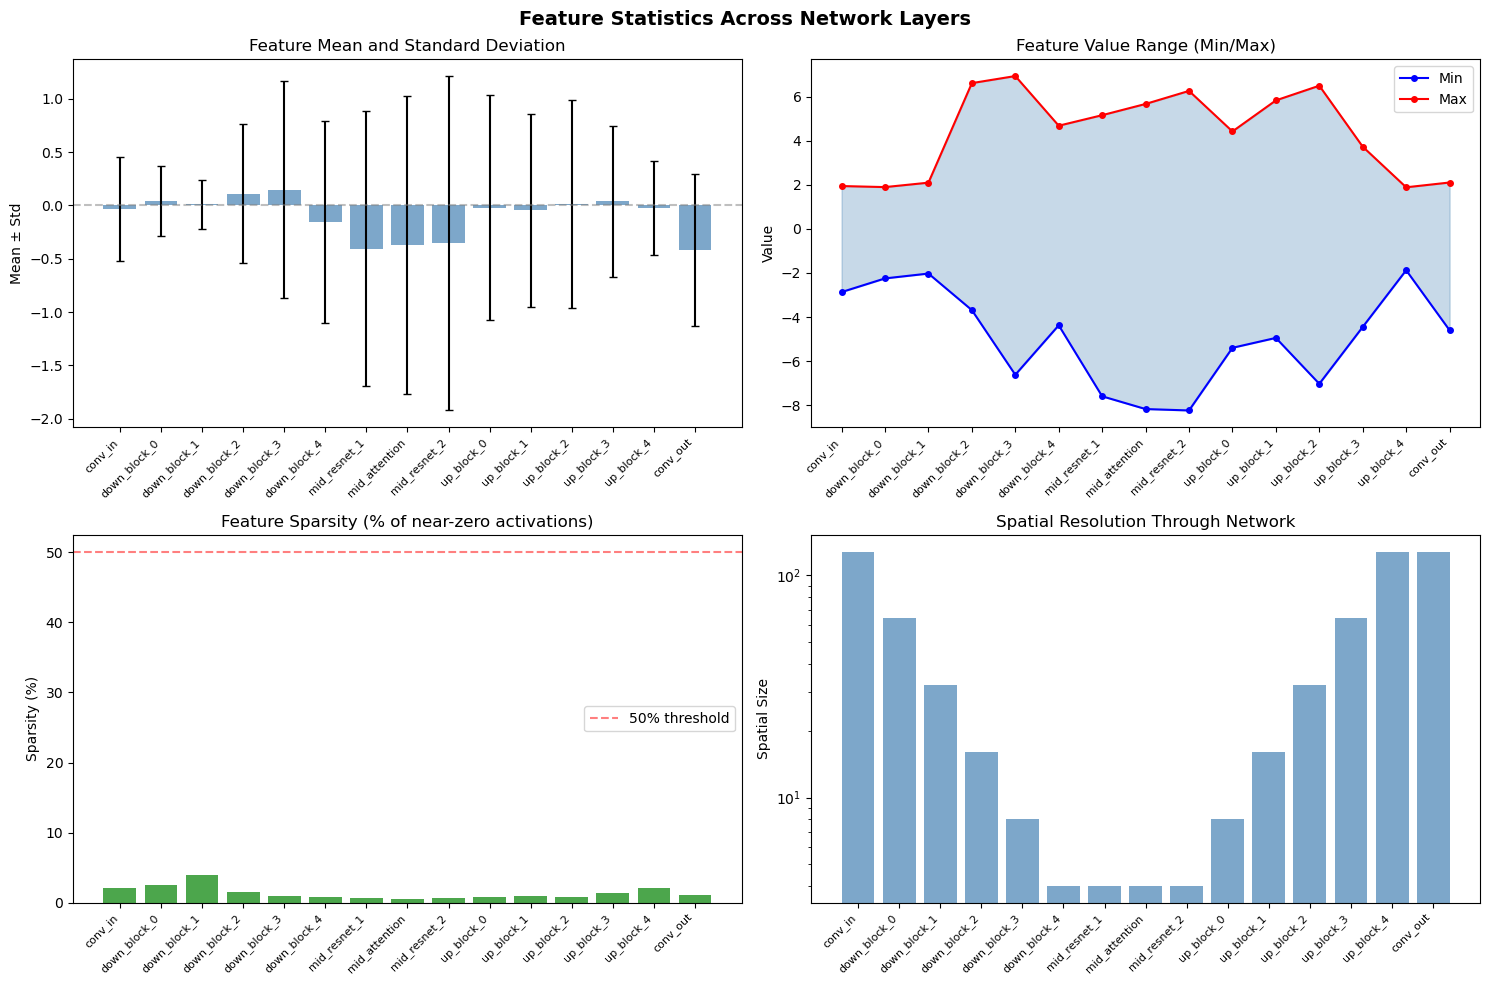

In [44]:
def get_short_name(layer_path):
    """Extract a short display name from layer path."""
    # Handle common layer naming patterns
    parts = layer_path.split('.')
    if len(parts) > 2:
        return '.'.join(parts[-2:])
    return layer_path

def visualize_feature_statistics(stats, figsize=(15, 10)):
    """
    Visualize feature statistics across layers.
    """
    layer_names = list(stats.keys())
    n_layers = len(layer_names)
    
    # Extract values
    means = [stats[k]['mean'] for k in layer_names]
    stds = [stats[k]['std'] for k in layer_names]
    mins = [stats[k]['min'] for k in layer_names]
    maxs = [stats[k]['max'] for k in layer_names]
    sparsities = [stats[k]['sparsity'] for k in layer_names]
    spatial_sizes = [stats[k]['spatial_size'] or 0 for k in layer_names]
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Mean ± Std
    ax = axes[0, 0]
    x = np.arange(n_layers)
    ax.bar(x, means, yerr=stds, capsize=3, alpha=0.7, color='steelblue')
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Mean ± Std')
    ax.set_title('Feature Mean and Standard Deviation')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 2: Min/Max Range
    ax = axes[0, 1]
    ax.fill_between(x, mins, maxs, alpha=0.3, color='steelblue')
    ax.plot(x, mins, 'o-', label='Min', color='blue', markersize=4)
    ax.plot(x, maxs, 'o-', label='Max', color='red', markersize=4)
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Value')
    ax.set_title('Feature Value Range (Min/Max)')
    ax.legend()
    
    # Plot 3: Sparsity
    ax = axes[1, 0]
    colors = ['red' if s > 0.5 else 'green' if s < 0.1 else 'steelblue' for s in sparsities]
    ax.bar(x, [s * 100 for s in sparsities], color=colors, alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Sparsity (%)')
    ax.set_title('Feature Sparsity (% of near-zero activations)')
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.legend()
    
    # Plot 4: Spatial Size
    ax = axes[1, 1]
    ax.bar(x, spatial_sizes, color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Spatial Size')
    ax.set_title('Spatial Resolution Through Network')
    ax.set_yscale('log')
    
    plt.suptitle('Feature Statistics Across Network Layers', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compute and visualize statistics
stats = analyze_feature_statistics(features)
visualize_feature_statistics(stats)

## 5. 🎬 FiLM Layer Analysis

Analyze how FiLM (Feature-wise Linear Modulation) layers modulate features based on time and parameter conditioning.

In [51]:
def extract_film_modulation(score_model, z, conditioning, timesteps=[0.0, 0.5, 1.0], param_conditioning=None):
    """
    Extract FiLM modulation parameters (gamma, beta) at different timesteps.
    
    Args:
        score_model: The UNet score model
        z: Target tensor (B, C, H, W)
        conditioning: Conditioning tensor (B, C_cond, H, W)
        timesteps: List of normalized timesteps [0, 1]
        param_conditioning: Optional parameter conditioning
    """
    film_data = {}
    
    # Find all ResNet blocks with FiLM layers
    film_layers = []
    for name, module in score_model.named_modules():
        if hasattr(module, 'film_layer') and module.film_layer is not None:
            film_layers.append((name, module.film_layer))  # Get the film_layer directly
    
    if not film_layers:
        print("No FiLM layers found in model")
        return None
    
    print(f"Found {len(film_layers)} FiLM layers")
    
    for t in timesteps:
        g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], device=device)
        
        # Compute conditioning embedding (same as what the model does internally)
        g_t_rescaled = (g_t - gamma_min) / (gamma_max - gamma_min)
        t_embedding = networks.get_timestep_embedding(g_t_rescaled, score_model.embedding_dim)
        t_cond = score_model.embed_t_conditioning(t_embedding)
        
        if score_model.use_param_conditioning and param_conditioning is not None:
            param_emb = score_model.param_conditioning_embedding(param_conditioning)
            combined_cond = torch.cat([score_model.time_scale * t_cond, score_model.param_scale * param_emb], dim=-1)
            combined_cond = score_model.conditioning_fusion(combined_cond)
        else:
            combined_cond = t_cond
        
        # Extract FiLM parameters from each layer by calling film_proj directly
        film_data[t] = {}
        for name, film_layer in film_layers:
            # Call the projection layer directly to get gamma and beta
            film_params = film_layer.film_proj(combined_cond)  # (B, C*2)
            gamma, beta = film_params.chunk(2, dim=1)  # (B, C) each
            # Note: In the actual forward pass, gamma gets +1 added, but we show raw values here
            film_data[t][name] = {
                'gamma': (gamma + 1.0).detach().cpu(),  # Add 1 to show effective gamma
                'beta': beta.detach().cpu()
            }
    
    return film_data

Found 12 FiLM layers


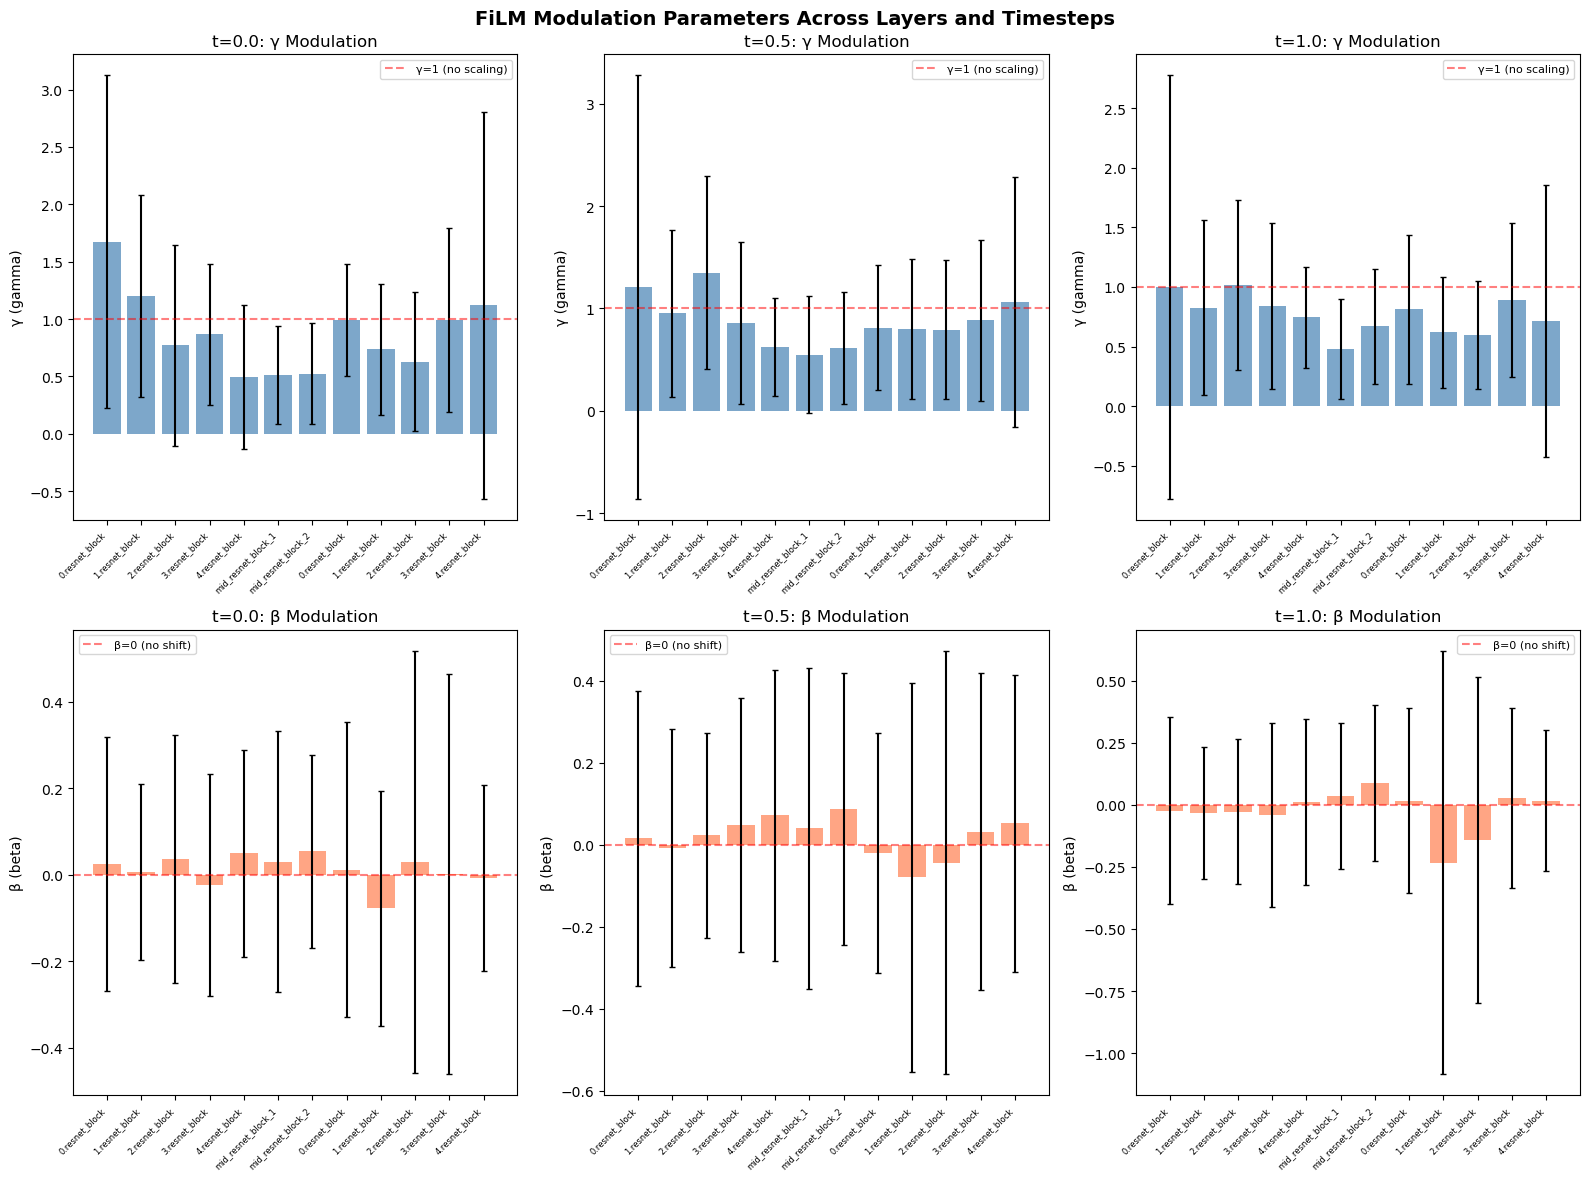

In [52]:
def visualize_film_modulation(film_data, figsize=(16, 12)):
    """
    Visualize FiLM modulation across layers and timesteps.
    """
    if film_data is None:
        return
    
    timesteps = sorted(film_data.keys())
    layer_names = list(film_data[timesteps[0]].keys())
    n_layers = len(layer_names)
    n_times = len(timesteps)
    
    fig, axes = plt.subplots(2, n_times, figsize=figsize)
    
    for col, t in enumerate(timesteps):
        # Gamma values
        ax = axes[0, col]
        gamma_means = [film_data[t][name]['gamma'].mean().item() for name in layer_names]
        gamma_stds = [film_data[t][name]['gamma'].std().item() for name in layer_names]
        
        x = np.arange(n_layers)
        ax.bar(x, gamma_means, yerr=gamma_stds, capsize=2, alpha=0.7, color='steelblue')
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='γ=1 (no scaling)')
        ax.set_xticks(x)
        ax.set_xticklabels([get_short_name(n) for n in layer_names], rotation=45, ha='right', fontsize=6)
        ax.set_ylabel('γ (gamma)')
        ax.set_title(f't={t:.1f}: γ Modulation')
        ax.legend(fontsize=8)
        
        # Beta values
        ax = axes[1, col]
        beta_means = [film_data[t][name]['beta'].mean().item() for name in layer_names]
        beta_stds = [film_data[t][name]['beta'].std().item() for name in layer_names]
        
        ax.bar(x, beta_means, yerr=beta_stds, capsize=2, alpha=0.7, color='coral')
        ax.axhline(y=0.0, color='red', linestyle='--', alpha=0.5, label='β=0 (no shift)')
        ax.set_xticks(x)
        ax.set_xticklabels([get_short_name(n) for n in layer_names], rotation=45, ha='right', fontsize=6)
        ax.set_ylabel('β (beta)')
        ax.set_title(f't={t:.1f}: β Modulation')
        ax.legend(fontsize=8)
    
    plt.suptitle('FiLM Modulation Parameters Across Layers and Timesteps', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Extract and visualize FiLM modulation
film_data = extract_film_modulation(score_model, target, condition, param_conditioning=param)
if film_data:
    visualize_film_modulation(film_data)

## 6. 🎞️ Denoising Trajectory

Visualize how the model progressively denoises from pure noise to the final prediction.

In [53]:
def compute_denoising_trajectory(score_model, target, condition, n_steps=10, param_conditioning=None):
    """
    Compute the x0 prediction at multiple noise levels to show denoising trajectory.
    
    Args:
        score_model: The UNet score model
        target: Ground truth target (B, 3, H, W)
        condition: Conditioning tensor (B, C_cond, H, W)
        n_steps: Number of timesteps to visualize
        param_conditioning: Optional parameter conditioning
    """
    score_model.eval()
    timesteps = np.linspace(0.95, 0.05, n_steps)  # High noise to low noise
    
    trajectory = []
    
    with torch.no_grad():
        for t in timesteps:
            # Ensure float32 dtype
            g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], 
                              device=device, dtype=torch.float32)
            
            # Add noise
            noise = torch.randn_like(target)
            alpha_t = torch.sqrt(torch.sigmoid(-g_t)).view(-1, 1, 1, 1).float()
            sigma_t = torch.sqrt(torch.sigmoid(g_t)).view(-1, 1, 1, 1).float()
            z_noisy = alpha_t * target + sigma_t * noise
            
            # Get model prediction (score/noise estimate)
            output = score_model(z_noisy, g_t, conditioning=condition, param_conditioning=param_conditioning)
            
            if isinstance(output, tuple):
                prediction = output[0]
            else:
                prediction = output
            
            trajectory.append({
                't': t,
                'noisy': z_noisy.cpu(),
                'prediction': prediction.cpu()
            })
    
    return trajectory

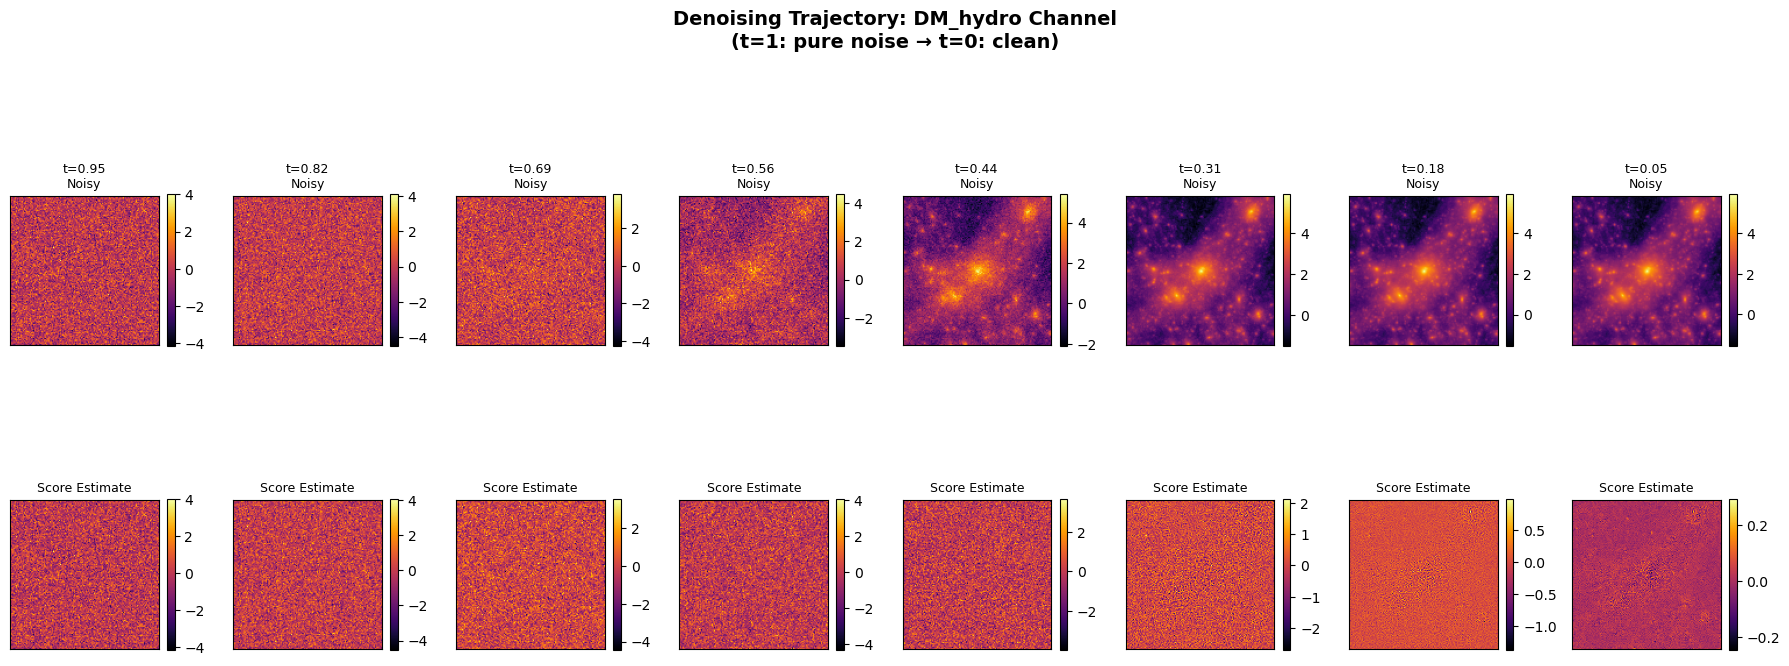

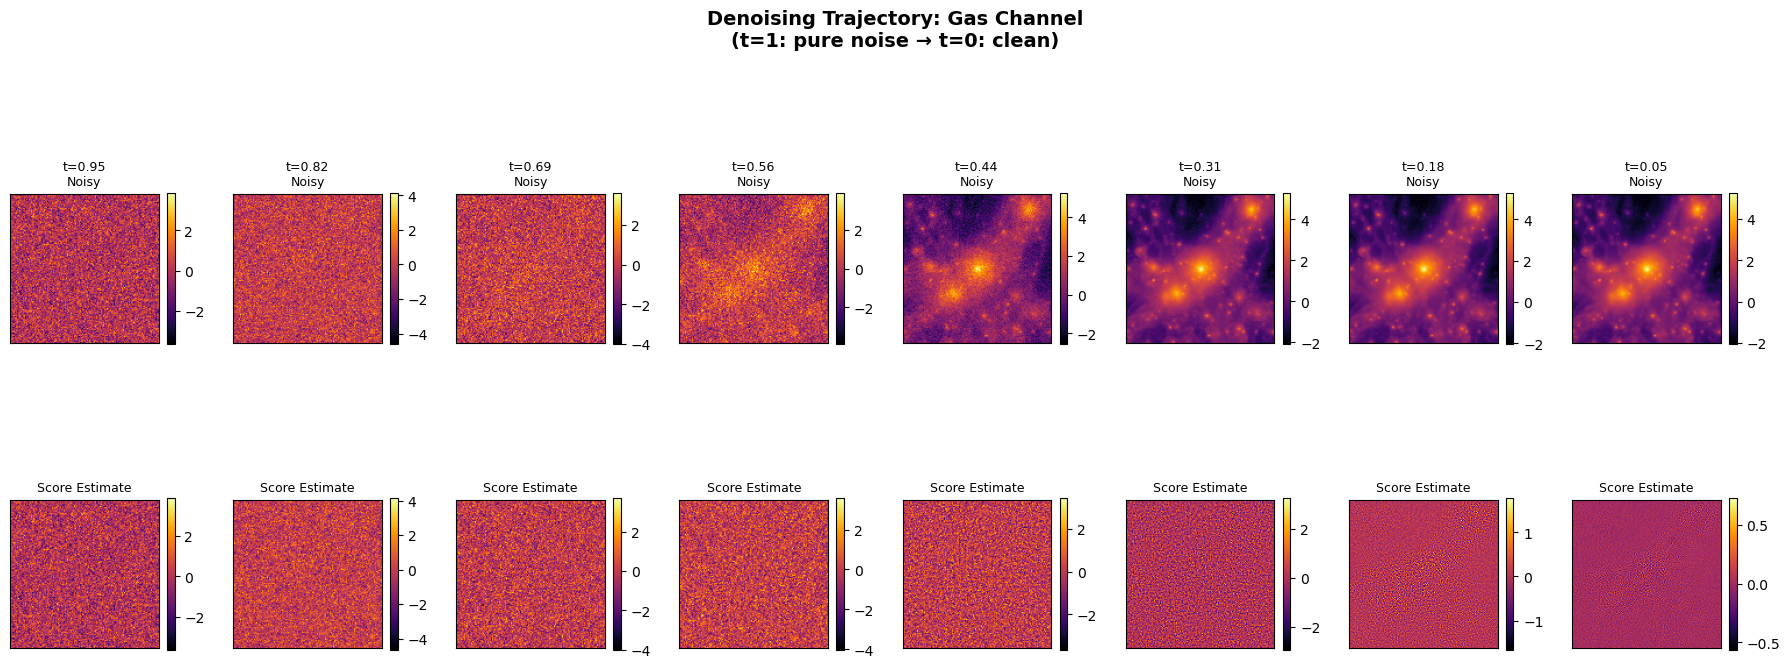

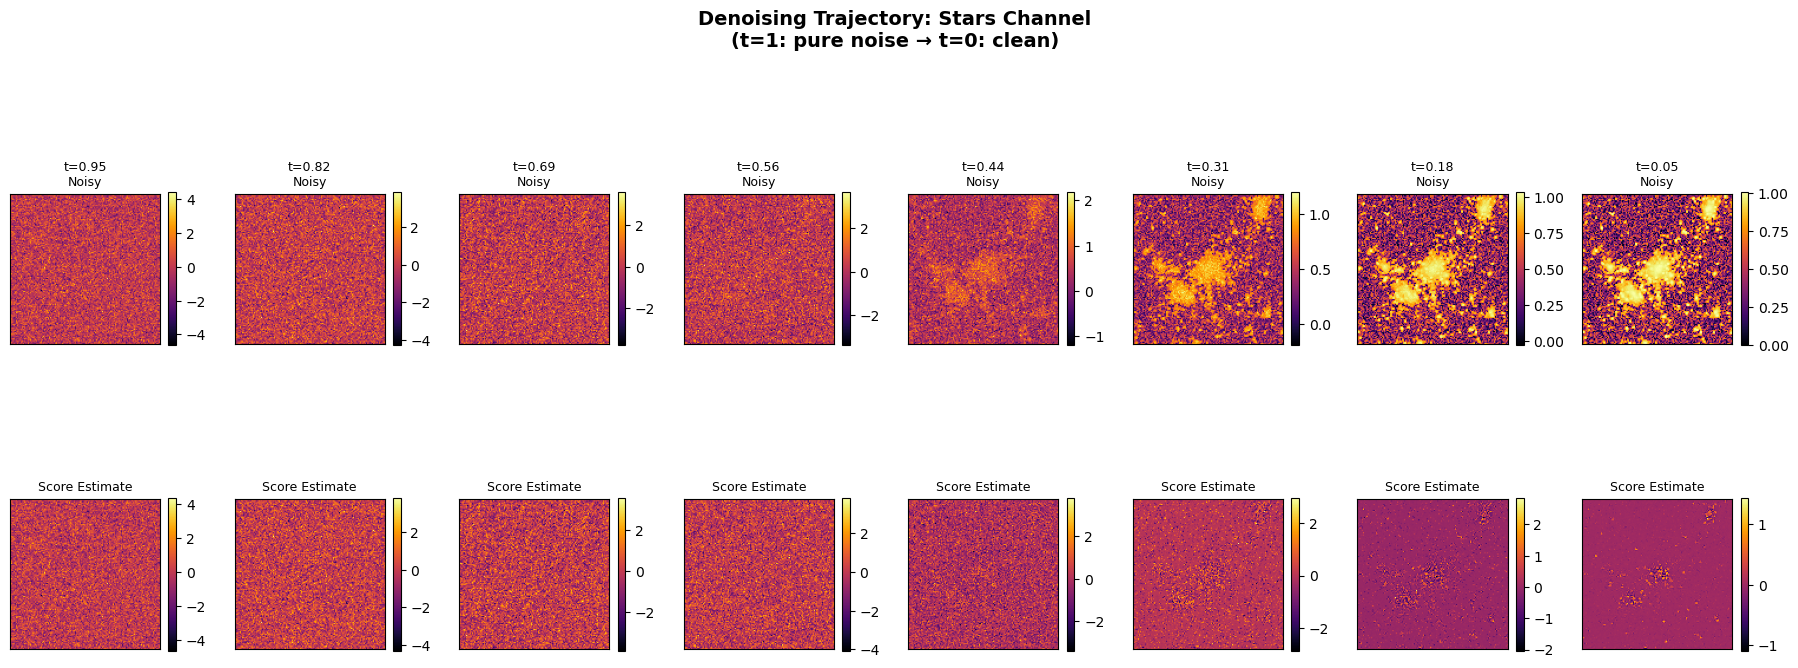

In [54]:
def visualize_denoising_trajectory(trajectory, channel=0, figsize=(18, 8)):
    """
    Visualize the denoising trajectory for a specific channel.
    """
    channel_names = ['DM_hydro', 'Gas', 'Stars']
    n_steps = len(trajectory)
    
    fig, axes = plt.subplots(2, n_steps, figsize=figsize)
    
    for i, step in enumerate(trajectory):
        # Noisy input
        ax = axes[0, i]
        im = ax.imshow(step['noisy'][0, channel].numpy(), cmap='inferno')
        plt.colorbar(im, ax=ax, fraction=0.046)
        ax.set_title(f't={step["t"]:.2f}\nNoisy', fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Prediction (score estimate)
        ax = axes[1, i]
        im = ax.imshow(step['prediction'][0, channel].numpy(), cmap='inferno')
        plt.colorbar(im, ax=ax, fraction=0.046)
        ax.set_title('Score Estimate', fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f'Denoising Trajectory: {channel_names[channel]} Channel\n(t=1: pure noise → t=0: clean)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compute and visualize trajectory
trajectory = compute_denoising_trajectory(score_model, target, condition, n_steps=8, param_conditioning=param)

# Visualize for each channel
for ch in range(3):
    visualize_denoising_trajectory(trajectory, channel=ch)

## 7. 📈 Channel Difficulty Analysis

Compare prediction errors across channels to understand which physical fields are hardest to model.

In [57]:
def analyze_channel_difficulty(score_model, target, condition, n_samples=10, param_conditioning=None):
    """
    Analyze prediction error per channel at different noise levels.
    
    Args:
        score_model: The UNet score model
        target: Ground truth target (B, 3, H, W)
        condition: Conditioning tensor (B, C_cond, H, W)
        n_samples: Number of noise samples to average
        param_conditioning: Optional parameter conditioning
    """
    score_model.eval()
    timesteps = np.linspace(0.1, 0.9, 9)
    n_channels = target.shape[1]
    channel_names = ['DM_hydro', 'Gas', 'Stars']
    
    errors = {ch: {t: [] for t in timesteps} for ch in range(n_channels)}
    
    with torch.no_grad():
        for _ in range(n_samples):
            for t in timesteps:
                # Ensure float32 dtype
                g_t = torch.tensor([t * (gamma_max - gamma_min) + gamma_min], 
                                  device=device, dtype=torch.float32)
                
                # Add noise
                noise = torch.randn_like(target)
                alpha_t = torch.sqrt(torch.sigmoid(-g_t)).view(-1, 1, 1, 1).float()
                sigma_t = torch.sqrt(torch.sigmoid(g_t)).view(-1, 1, 1, 1).float()
                z_noisy = alpha_t * target + sigma_t * noise
                
                # Get prediction (score estimate)
                output = score_model(z_noisy, g_t, conditioning=condition, param_conditioning=param_conditioning)
                if isinstance(output, tuple):
                    prediction = output[0]
                else:
                    prediction = output
                
                # Compute per-channel MSE between score prediction and noise
                # (VDM predicts the noise, so compare to actual noise added)
                for ch in range(n_channels):
                    mse = ((prediction[0, ch] - noise[0, ch]) ** 2).mean().item()
                    errors[ch][t].append(mse)
    
    # Aggregate
    results = {}
    for ch in range(n_channels):
        results[channel_names[ch]] = {
            'timesteps': timesteps,
            'mean_errors': [np.mean(errors[ch][t]) for t in timesteps],
            'std_errors': [np.std(errors[ch][t]) for t in timesteps]
        }
    
    return results

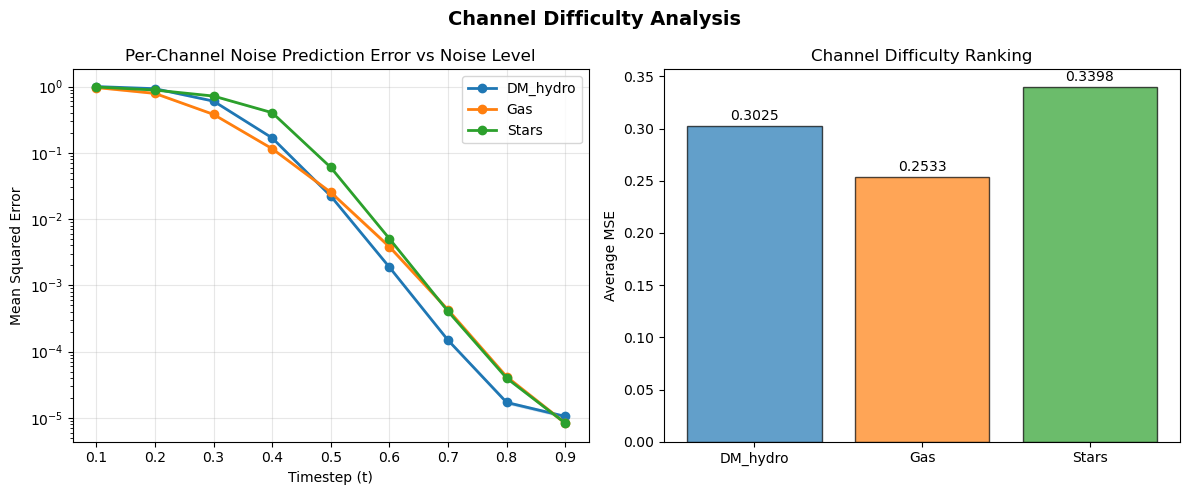

In [58]:
def visualize_channel_difficulty(results, figsize=(12, 5)):
    """
    Visualize per-channel difficulty.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot 1: Error vs timestep
    for i, (ch_name, data) in enumerate(results.items()):
        ax1.plot(data['timesteps'], data['mean_errors'], 'o-', 
                 label=ch_name, color=colors[i], linewidth=2, markersize=6)
        ax1.fill_between(
            data['timesteps'],
            np.array(data['mean_errors']) - np.array(data['std_errors']),
            np.array(data['mean_errors']) + np.array(data['std_errors']),
            alpha=0.2, color=colors[i]
        )
    
    ax1.set_xlabel('Timestep (t)')
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title('Per-Channel Noise Prediction Error vs Noise Level')
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Average difficulty ranking
    avg_errors = [np.mean(data['mean_errors']) for data in results.values()]
    ch_names = list(results.keys())
    
    bars = ax2.bar(ch_names, avg_errors, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Average MSE')
    ax2.set_title('Channel Difficulty Ranking')
    
    # Add value labels on bars
    for bar, val in zip(bars, avg_errors):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(avg_errors),
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.suptitle('Channel Difficulty Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Analyze and visualize
channel_results = analyze_channel_difficulty(score_model, target, condition, param_conditioning=param)
visualize_channel_difficulty(channel_results)

## 8. 📝 Summary and Key Insights

Compile the key findings from the interpretability analysis.

In [59]:
def print_summary():
    print("\n" + "="*70)
    print("📋 INTERPRETABILITY ANALYSIS SUMMARY")
    print("="*70)
    
    print("\n🔬 MODEL ARCHITECTURE:")
    print(f"   - Parameters: {count_parameters(score_model):,}")
    print(f"   - Embedding dim: {score_model.embedding_dim}")
    print(f"   - Down blocks: {len(score_model.down_blocks)}")
    print(f"   - Uses cross-attention: {score_model.use_cross_attention}")
    print(f"   - Uses param conditioning: {score_model.use_param_conditioning}")
    
    print("\n🔥 SALIENCY INSIGHTS:")
    print("   - Check which input regions most influence predictions")
    print("   - Higher saliency = more important for denoising")
    print("   - Compare saliency across channels to see feature importance")
    
    print("\n🧠 BOTTLENECK FEATURES:")
    print("   - Compressed representation of input")
    print("   - Should capture multi-scale structure")
    print("   - Sparse features may indicate underfitting")
    
    print("\n🎬 FiLM MODULATION:")
    print("   - γ ≈ 1: No scaling modulation")
    print("   - β ≈ 0: No shift modulation")
    print("   - Stronger modulation = more time-dependent processing")
    
    print("\n📊 CHANNEL DIFFICULTY:")
    print("   - Stars typically hardest (sparse signal)")
    print("   - DM typically easiest (smooth field)")
    print("   - Consider increasing weight for hard channels")
    
    print("\n" + "="*70)

print_summary()


📋 INTERPRETABILITY ANALYSIS SUMMARY

🔬 MODEL ARCHITECTURE:
   - Parameters: 247,765,832
   - Embedding dim: 96
   - Down blocks: 5
   - Uses cross-attention: False
   - Uses param conditioning: True

🔥 SALIENCY INSIGHTS:
   - Check which input regions most influence predictions
   - Higher saliency = more important for denoising
   - Compare saliency across channels to see feature importance

🧠 BOTTLENECK FEATURES:
   - Compressed representation of input
   - Should capture multi-scale structure
   - Sparse features may indicate underfitting

🎬 FiLM MODULATION:
   - γ ≈ 1: No scaling modulation
   - β ≈ 0: No shift modulation
   - Stronger modulation = more time-dependent processing

📊 CHANNEL DIFFICULTY:
   - Stars typically hardest (sparse signal)
   - DM typically easiest (smooth field)
   - Consider increasing weight for hard channels



---

## Next Steps

1. **Analyze multiple samples**: Loop over many test samples for robust statistics
2. **Compare models**: Load different checkpoints to compare what they learn
3. **Extend analysis**: Add PCA/UMAP of bottleneck features, attention map visualization
4. **Save figures**: Use `plt.savefig()` for paper-quality figures